In [1]:
import math

import numpy as np
import sklearn.datasets as ds
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch import nn
from torch.optim import SGD, Adam
import torch.nn.functional as F

%matplotlib inline

# Примеры функций активации:

1. Сигмоида: $$\sigma(x) = \frac{1}{1 + e^{-x}}$$
2. Гиперболический тангендс: $$\text{th}(x)=\frac{\operatorname{sh}x}{\operatorname{ch}x} = \frac {e^x - e^{-x}} {e^x + e^{-x}} = \frac{e^{2x} - 1} {e^{2x} + 1}$$
3. ReLU: $$\text{relu}(x) = x^+ = \max(0, x)$$
4. HardShrink $$\text{HardShrink}(x) =
        \begin{cases}
        x, & \text{ if } x > \lambda \\
        x, & \text{ if } x < -\lambda \\
        0, & \text{ otherwise }
        \end{cases}$$

In [2]:
torch.sigmoid(torch.tensor(100.))

tensor(1.)

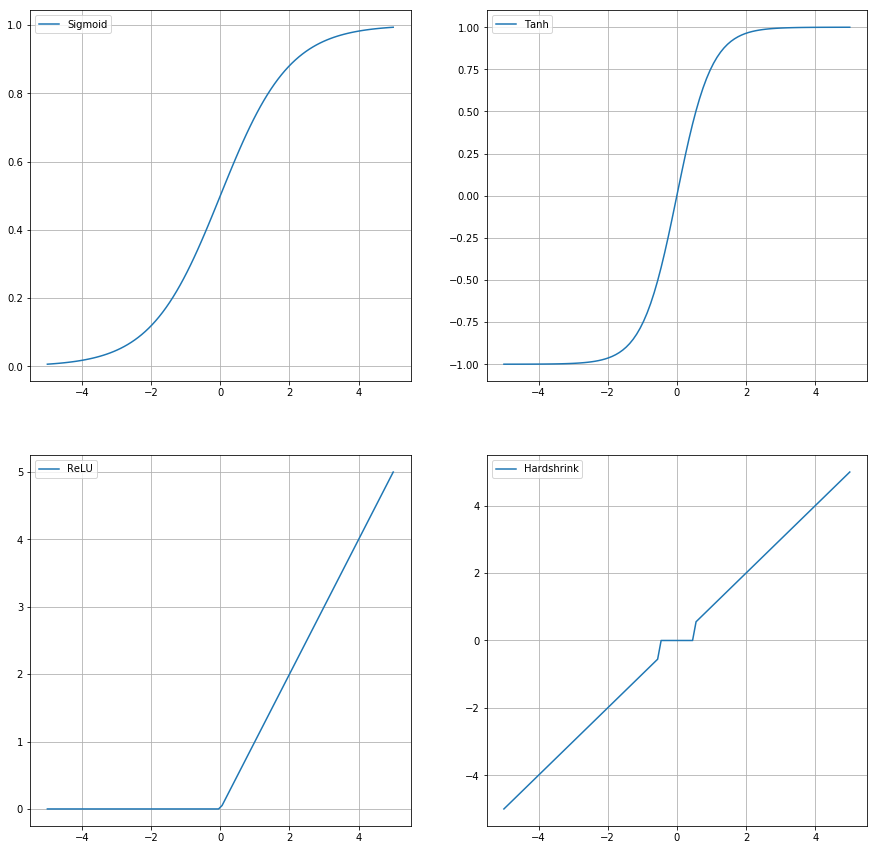

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))


funcs = [torch.sigmoid, torch.tanh, torch.relu, nn.Hardshrink()]
names = ['Sigmoid', 'Tanh', 'ReLU', 'Hardshrink']

for ax, func, name in zip(axes.flatten(), funcs, names):
    x = np.linspace(-5, 5, 100)
    y = func(torch.tensor(x))
    ax.plot(x, y)
    ax.grid(True)
    ax.legend([name])

# Базовые слои

### Линейный

In [4]:
layer = nn.Linear(5, 2)
x = torch.randn(5)
layer(x)

tensor([-0.2692, -0.3369], grad_fn=<AddBackward0>)

In [5]:
batch = torch.randn((3, 5))
layer(batch)

tensor([[ 0.4239,  0.6906],
        [-0.9594, -0.7684],
        [ 0.3026,  0.0260]], grad_fn=<AddmmBackward>)

### Embedding

In [6]:
layer = nn.Embedding(5, 4)
layer(torch.LongTensor([[2, 2, 3, 0], 
                        [0, 0, 1, 2]]))

tensor([[[-1.8219, -0.4213,  1.8777,  1.7274],
         [-1.8219, -0.4213,  1.8777,  1.7274],
         [-2.3641, -0.1370, -1.7978,  1.9211],
         [-0.6822, -0.4344,  0.4308,  0.3011]],

        [[-0.6822, -0.4344,  0.4308,  0.3011],
         [-0.6822, -0.4344,  0.4308,  0.3011],
         [-0.3681, -0.7747,  1.2361,  0.9262],
         [-1.8219, -0.4213,  1.8777,  1.7274]]], grad_fn=<EmbeddingBackward>)

### Dropout

In [7]:
layer = nn.Dropout(0.5)
batch = torch.randn((3, 5))
layer.train()
layer(batch)

tensor([[-0.7165,  0.0000, -6.0201,  2.4007, -0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.9781,  4.0054],
        [ 2.5640, -0.0000,  0.3959, -0.2792,  0.1148]])

### Batch Normalization

In [8]:
layer = nn.BatchNorm1d(5)
batch = torch.randn((3, 5))
res = layer(batch)
res, res.sum(0)

(tensor([[ 0.1309, -1.1712, -1.4029,  1.2432,  1.2179],
         [ 1.1539,  1.2720,  0.8558, -0.0379, -1.2315],
         [-1.2848, -0.1008,  0.5471, -1.2054,  0.0136]],
        grad_fn=<NativeBatchNormBackward>),
 tensor([ 3.5763e-07, -2.9802e-08, -5.9605e-08,  1.1921e-07, -9.8720e-08],
        grad_fn=<SumBackward1>))

# Классификация цифр

In [9]:
X, y = ds.load_digits(n_class=2, return_X_y=True)
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view((-1, 1))

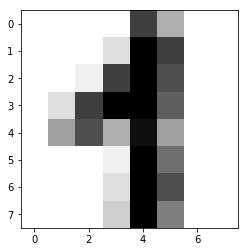

In [10]:
plt.imshow(X[8].numpy().reshape((8, 8)), cmap='binary')

In [11]:
l = X.size(0)
l_train, l_test = int(l * 0.7), int(l * 0.2)

data = TensorDataset(X, y)
train_ds, test_ds, val_ds = random_split(data, [l_train, l_test, l - l_train - l_test])

In [17]:
class DigitsClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(64, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    

In [18]:
def test_model(model, ds):
    with torch.no_grad():
        currect = 0
        total = 0
        for X_val, y_val in ds:
            y_pred = (model(X_val) >= 0.5)
            y_val = (y_val >= 0.5)

            currect += y_pred.eq(y_val).sum().item()
            total += X_val.size(0)
       
        return currect / total
    

def train_model(model):
    optimizer = SGD(model.parameters(), lr=1e-3)

    loss = nn.BCELoss()
    train_loader = DataLoader(dataset=train_ds, batch_size=30)
    val_loader = DataLoader(dataset=val_ds)
    test_loader = DataLoader(dataset=test_ds)

    max_epochs = 100
    for epoch in range(max_epochs):
        for X_batch, y_batch in train_loader:   
            y_pred = model(X_batch)    
            bce = loss(y_pred, y_batch)

            bce.backward()        

            optimizer.step()
            optimizer.zero_grad()       
           
        
        if epoch % 30 == 0:
            acc = test_model(model, val_loader)
            print(f'Epoch = {epoch}, acc = {acc:.5f}, loss = {bce}')    
            
    print(f'Test results acc = {test_model(model, test_loader):.5f}')       
    
model = DigitsClassifier()    
train_model(model)               

Epoch = 0, acc = 0.94595, loss = 0.20720261335372925
Epoch = 30, acc = 1.00000, loss = 0.014759978279471397
Epoch = 60, acc = 1.00000, loss = 0.007636405061930418
Epoch = 90, acc = 1.00000, loss = 0.005134155973792076
Test results acc = 1.00000


In [19]:
model(X[9])

tensor([0.9997], grad_fn=<SigmoidBackward>)

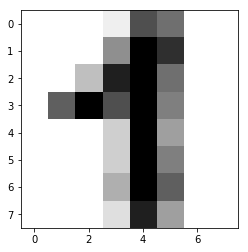

In [20]:
plt.imshow(X[9].numpy().reshape((8, 8)), cmap='binary')